# It's like Dark Souls meets Breath of the Wild
> Scraping data from metacritic to estimate similarity of different games.

- toc: true 
- badges: true
- comments: true
- categories: [text-extraction, code]
- hide: false
- image: images/chart-preview.png

In [1]:
#hide
#library import
import requests
from bs4 import BeautifulSoup
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t.lower()) for t in word_tokenize(articles) if t.isalnum()]

In [2]:
#hide
#custom functions and games
#do something better than this
games = ['elden-ring', 'the-stanley-parable-ultra-deluxe', 'horizon-forbidden-west', 'gran-turismo-7',
        'uncharted-legacy-of-thieves-collection', 'destiny-2-the-witch-queen', 'crusader-kings-iii-console-edition',
        'olliolli-world', 'lego-star-wars-the-skywalker-saga', 'this-war-of-mine-final-cut',
        'grand-theft-auto-v', 'far-changing-tides', 'sifu', 'sonic-origins',
        'assetto-corsa-competizione', 'road-96', 'the-king-of-fighters-xv', 
        'souldiers', 'chernobylite', 'mlb-the-show-22', 
        'grid-legends', 'relayer', 'sniper-elite-5', 'wwe-2k22', 'vampire-the-masquerade---bloodhunt',
        'the-ascent', 'motogp-22', 'salt-and-sacrifice', 'lost-judgment-the-kaito-files', 
        'dying-light-2-stay-human', 'tiny-tinas-wonderlands', 'eiyuden-chronicle-rising',
        'ghostwire-tokyo', 'cyberpunk-2077', 'monster-energy-supercross---the-official-videogame-5',
        'tom-clancys-rainbow-six-extraction', 'the-quarry', 'submerged-hidden-depths',
        'evil-dead-the-game', 'stranger-of-paradise-final-fantasy-origin', 'martha-is-dead',
        'anno-mutationem', 'a-memoir-blue', 'the-centennial-case-a-shijima-story', 'assassins-creed-valhalla-dawn-of-ragnarok'
        ]
console = 'playstation-5'

def get_data(console, game):
    
    url = f'https://www.metacritic.com/game/{console}/{game}/'
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)

    soup = BeautifulSoup(response.text, 'html.parser')
    
    if soup.find('span', class_='blurb blurb_expanded'):
        blurb = soup.find('span', class_='blurb blurb_expanded').text
    else: 
        blurb = ''
    rating = soup.find('span', itemprop='ratingValue').text
    
    d = {
            'game_name':[game],
            'console_name':[console],
            'rating_name':[rating],
            'blurb_long':[blurb]
        }
    df = pd.DataFrame(d)
    
    return df

def get_critic_data(console, games):
    
    blurb_df = pd.DataFrame()
    
    for g in games:
        tmp_df = get_data(console, g)
        blurb_df = blurb_df.append(tmp_df)
    
    return blurb_df

## Nerdy Filler

I love games. I'm not good at them, but I love them nonetheless. I spend a lot of time looking at metacritic, searching for the next game I wanna play. I wouldn't say I have a huge amount of time to trial games - so, whilst it's not life and death, it would be good to go into purchasing a game with some confidence I'll enjoy it.

Now, it's obvious that building a homemade recommender system for video games will always struggle up against what the Sony/Microsoft/Nintendo can build - these companies will have masses of user data, and should be able to build pretty strong collaborative filter type systems.

And also, this quick article isn't even going to start on that recommender system (why would I open myself up to judgement on the games I play??). What I want to do in here is talk about how we'd go about creating some useful data, that could then be used in a recommender system. 

## Summarising the summaries

One of the best sites for exploring which games to play next, is [metacritic](www.metacritic.com). This collects multiple reviews from critics/users and aggregates these into ratings. They also provide summary information on games and this is where we'll collect and transform into useful features for games.

![](metacritic/elden-ring.png)

There's a lot of useful data on that page, but we're going to focus solely on the `summary` for now and for ease we're going to collect ~50 games that have been released on the PS5 in the last year. Naturally with data like this, more is always better than less - but the process can remain the same.

## Scraping Away

The first thing we need to do is to loop through a list of games, collecting the summary for each of these. I tend to lean towards doing this in a pandas dataframe (though there will be more efficient ways of storing this; I just come from an R background and it's my preference for exploration). 
There's a good article on scraping reviews from metacritic [here](https://towardsdatascience.com/web-scraping-metacritic-reviews-using-beautifulsoup-63801bbe200e) which we have adapted to collect the summary instead.

In [3]:
#hide-input
critic_df = get_critic_data(console=console, games=games)
critic_df = critic_df.reset_index(drop=True)
critic_df.head()

,game_name,console_name,rating_name,blurb_long
0,elden-ring,playstation-5,96,A New World Created By Hidetaka Miyazaki And G...
1,the-stanley-parable-ultra-deluxe,playstation-5,89,2013's The stanley parable is a classic. Full ...
2,horizon-forbidden-west,playstation-5,88,Join Aloy as she braves the Forbidden West – a...
3,gran-turismo-7,playstation-5,87,From classic vehicles and tracks to the reintr...
4,uncharted-legacy-of-thieves-collection,playstation-5,87,"The game looks absolutely stellar on PS5, and ..."


## Turning text into something useful

This provides us with a single column for the whole summary, which is great - but not really that useful for any future processes.

We'll treat this text data with the following steps:
- Cleaning - we want to turn the data into lowercase to ensure each of the records are consistent. We don't want a situation where our code sees "classic" and "Classic" as two different words
- Tokenisation - this is a way of splitting long text-objects into distinct tokens. The simplest example is single word tokenisation, where we can take a sentence `'this is a game'` and split into a list of words `['this', 'is', 'a', 'game']`
- Lemmatisation - this process will ensure that tenses of words are meaningless, and words such as 'run', 'ran' and 'running' will all match to the same root word
- Vectorisation - once we've split the words into tokens, we can then transform the data into a matrix of token occurences. At this step we'll also strip out domain specific stop words (done via `max_df`) and words that are completely unique to few records (done via `min_df`)

At the end of that process we have something like this:

In [4]:
#hide
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',  
                                #stop_words = 'english', 
                                lowercase = True, 
                                max_df = 0.8, 
                                min_df = 3, 
                                binary=True,
                                analyzer='word') 


X = vectorizer.fit_transform(critic_df['blurb_long'])
critic_df = pd.concat([critic_df, 
                       pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())], 
                      axis=1)

In [5]:
#hide-input
critic_df.head()

,game_name,console_name,rating_name,blurb_long,3d,ability,about,across,action,adventure,...,who,will,wit,with,within,world,year,you,your,zone
0,elden-ring,playstation-5,96,A New World Created By Hidetaka Miyazaki And G...,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
1,the-stanley-parable-ultra-deluxe,playstation-5,89,2013's The stanley parable is a classic. Full ...,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,horizon-forbidden-west,playstation-5,88,Join Aloy as she braves the Forbidden West – a...,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,gran-turismo-7,playstation-5,87,From classic vehicles and tracks to the reintr...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,uncharted-legacy-of-thieves-collection,playstation-5,87,"The game looks absolutely stellar on PS5, and ...",1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


## Reducing dimensionality

We end up with a whopping 325 additional columns which all represent a binary value as to whether that token appears in the summary text.
This is quite a lot of tokens, and truthfully some of them will still be pretty familiar and interchangeable - in order to reduce this further we can use a dimension reduction technique. There are many, we'll stick to a relatively simple Principal Components piece here - but may be worth investigating more graphical solutions (e.g. tSNE and uMAP). 

The idea behind this is to take those 325 columns and reduce them into, say, 2 components which can explain the majority of the variance between them. This is useful when starting to measure distance, where a simple Euclidean distance metric will suffer dramatically from the curse of dimensionality.

In [6]:
#hide
X = critic_df[vectorizer.get_feature_names()].to_numpy()
pca = PCA(n_components=2)
word_comps = pca.fit_transform(X)

critic_df = pd.concat([critic_df, pd.DataFrame(word_comps, columns = ['pca_1', 'pca_2'])], axis=1)

## But okay, what should I actually buy next?

So with this data we can now start making a stab at measuring how similar two games are to one another. Let's take an example. My favourite game this year is probably Elden Ring, but I've completed it now and whilst it's tempting to just start a new save, let's say I want to try something different - based on the summaries given on metacritic what would this simple method suggest?

So we have these two principal components, and when we plot a few games you can visually see the distance between a set of games. Take below, we can see that Elden Ring is closer to Sifu than it is Gran Turismo 7. And this makes sense, Sifu is much closer in genre (and difficulty!) than GT7 and you can kind of reason similarities between the two.

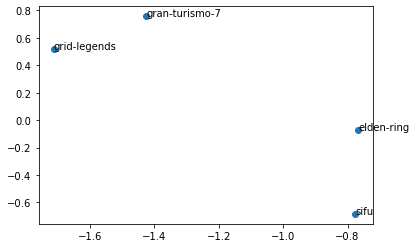

In [11]:
#hide-input
temp_games = ['elden-ring', 'gran-turismo-7', 'sifu', 'grid-legends']
critic_df_tmp = critic_df[critic_df.game_name.isin(temp_games)].reset_index()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(critic_df_tmp['pca_1'], critic_df_tmp['pca_2'])

for i, txt in enumerate(critic_df_tmp['game_name']):
    ax.annotate(txt, (critic_df_tmp['pca_1'][i], critic_df_tmp['pca_2'][i]))

We can even measure 'similarity' as just 1 over the euclidean distance between the two points. Therefore for Elden Ring we can ask for the most similar game we can find. 

In [31]:
#collapse-output
from scipy.spatial.distance import euclidean, pdist, squareform


def similarity_func(u, v):
    return 1/(1+euclidean(u,v))

dists = pdist(critic_df[['pca_1', 'pca_2']], similarity_func)
sim_df = pd.DataFrame(squareform(dists), columns=critic_df['game_name'], index=critic_df['game_name'])

sim_df['elden-ring']

game_name
elden-ring                                              0.000000
the-stanley-parable-ultra-deluxe                        0.178060
horizon-forbidden-west                                  0.414328
gran-turismo-7                                          0.486106
uncharted-legacy-of-thieves-collection                  0.394535
destiny-2-the-witch-queen                               0.506614
crusader-kings-iii-console-edition                      0.381153
olliolli-world                                          0.176593
lego-star-wars-the-skywalker-saga                       0.314269
this-war-of-mine-final-cut                              0.184829
grand-theft-auto-v                                      0.358598
far-changing-tides                                      0.565858
sifu                                                    0.620281
sonic-origins                                           0.550740
assetto-corsa-competizione                              0.421488
road-96        

So what game is next on my list? Well apparently this, but I'm really not sure...

![](metacritic/final-fantasy.png)


## Is it even good?

Okay, so the end result was a bit disappointing - I'm glad it didn't give me WWE 2k22 but it's still underwhelming. Were we looking to improve this we've got a lot of different avenues we can explore:

- Mo' games - we're only looking at <50 bestselling games on the PS5 from the current year, which is very limited in terms of sample of breadth.
- Mo' data - we're also only extracting the summary, we will definitely improve the process if we add additional features. On each game's homepage we have additional data like genre, rating, even developer - which would give us more belief in features used
- Better techniques - everything we've done here is pretty simple. There are many areas where we can improve and optimise - Named-entity Recognition may aid us in removing unhelpful nouns from the summary text; more diverse dimension reduction techniques could help us more accurately transpose the huge text data into more usable features; similarly NLP transformers could do this job for us in a more robust way, and could help with the lack of data.

Overall I think this gives some indication of the potential of freely available data we could use. One fear I have before going too far down this route, is how well text-processing techniques can deal with "creative" text data - I can see how a model can easily learn a relationship between more structured and consistent text (e.g. categorical labels, commerce receipts, chatbot data) where the text is chosen to be as clear and concise as possible. With reviews and summaries, critics will be encouraged to write creatively - to appeal to a human rather than be understood by a machine, and this could be where models find it increasingly difficult to pick out context (well, maybe AI will be fine? PLEASE? I HOPE?).